In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
from itertools import compress
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

Valid orders within 6 months in ES Shop (from 01/05/2018 to 30/11/2018) with a TC mapping

### Data loading, cleaning & formatting

In [3]:
data = pd.read_csv('6_months_orders_es_shop_blacklisting_patterns_v2.dsv', sep=';', low_memory=False)

In [4]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ
0,524887898,22/11/2018 17:33:15,124107261,5178295,4309655,1672001,2,6862,"1,79","48,01",30,19174
1,524887899,22/11/2018 17:33:15,124107261,5178295,4309655,2523879,1,83717,"11,99","48,01",30,19174
2,524887900,22/11/2018 17:33:15,124107261,5178295,4309655,2445754,1,77468,"4,99","48,01",30,19174
3,524887901,22/11/2018 17:33:15,124107261,5178295,4309655,1490212,1,60831,"3,99","48,01",30,19174
4,524887902,22/11/2018 17:33:15,124107261,5178295,4309655,497868,2,28128,"6,99","48,01",30,19174


In [5]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760593 entries, 0 to 2760592
Data columns (total 12 columns):
OP_ID               int64
O_DATE              object
O_ID                int64
O_K_ID              int64
TC_ID               int64
OP_AS_ID            int64
OP_AMOUNT           int64
APS_AP_ID           int64
OP_PRICE            object
O_GWERT             object
OSP_KO_COUNT_NET    int64
OCI_PLZ             object
dtypes: int64(8), object(4)
memory usage: 252.7+ MB


In [6]:
# check duplicates at an order position level 6_months_orders_es_shop_blacklisting_patterns_v2.dsv

In [7]:
data = data[~data['OP_ID'].duplicated()]

In [8]:
data[~data['OP_ID'].duplicated()]['OP_ID'].nunique(), len(data)

(2615509, 2615509)

In [9]:
data['O_DATE'] = pd.to_datetime(data['O_DATE'], format="%d/%m/%Y %H:%M:%S")

In [10]:
data['OP_PRICE'] = [float(str(i).replace(',','.')) for i in data['OP_PRICE'].values]
data['O_GWERT'] = [float(str(i).replace(',','.')) for i in data['O_GWERT'].values]

In [11]:
data['OCI_PLZ'] = [i.replace(' ', '') for i in data['OCI_PLZ'].values]

In [12]:
data['MAX_SALES_O_POS'] = data['OP_PRICE'].groupby(data['O_ID']).transform('max')
data['IS_LEAD_AS'] = (data['OP_PRICE'] == data['MAX_SALES_O_POS']) * 1 * data['OP_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['O_ID']).transform('max')

In [13]:
arts_to_pgs = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [14]:
arts_to_pgs = arts_to_pgs.fillna(0).astype(int)[['AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']]
arts_to_pgs.head()

,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,7,3,33,1053
1,28,418,1248,1261
2,33,2,15,94
3,40,6,1635,1664
4,41,6,1635,3116


In [15]:
data = data.merge(arts_to_pgs, left_on='APS_AP_ID', right_on='AP_ID', how='left')

In [16]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ,MAX_SALES_O_POS,IS_LEAD_AS,LEAD_AS_ID,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,524887898,2018-11-22 17:33:15,124107261,5178295,4309655,1672001,2,6862,1.79,48.01,30,19174,11.99,0,2523879,6862.0,5.0,51.0,832.0
1,524887899,2018-11-22 17:33:15,124107261,5178295,4309655,2523879,1,83717,11.99,48.01,30,19174,11.99,2523879,2523879,83717.0,3.0,252.0,257.0
2,524887900,2018-11-22 17:33:15,124107261,5178295,4309655,2445754,1,77468,4.99,48.01,30,19174,11.99,0,2523879,77468.0,6.0,67.0,1662.0
3,524887901,2018-11-22 17:33:15,124107261,5178295,4309655,1490212,1,60831,3.99,48.01,30,19174,11.99,0,2523879,60831.0,3.0,2068.0,2632.0
4,524887902,2018-11-22 17:33:15,124107261,5178295,4309655,497868,2,28128,6.99,48.01,30,19174,11.99,0,2523879,28128.0,3.0,2068.0,2632.0


### Order level

In [17]:
#Operations to do when grouping at order level
agg_ops = {'O_DATE': min,
          'O_K_ID': min, 
          'TC_ID': min,
          'OSP_KO_COUNT_NET': min,
          'O_GWERT': max,
          'APS_AP_ID': lambda x: list(x),
          'OP_AS_ID': [len, lambda x: list(x)],
          'OP_AMOUNT': lambda x: list(x),
          'LEAD_AS_ID': max,
          'L2_PG_ID': max,
          'L3_PG_ID': max,
          'L4_PG_ID': max,
          'OCI_PLZ': lambda x: list(set(list(x)))
          }

In [18]:
orders = data.groupby('O_ID', as_index=False).agg(agg_ops)

In [19]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [20]:
orders.columns = ['O_ID', 'O_DATE', 'O_K_ID', 'TC_ID', 'OSP_KO_COUNT_NET',
       'O_GWERT', 'APS_AP_ID_list', 'OP_AS_ID_len',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID',
       'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID', 'OCI_PLZ']

In [24]:
orders.head()

,O_ID,O_DATE,O_K_ID,TC_ID,OSP_KO_COUNT_NET,O_GWERT,APS_AP_ID_list,OP_AS_ID_len,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ,DATE_N_SV
0,109765643,2018-05-01 00:00:45,14980341,11139141,14,69.99,"[9795, 25854, 65427]",3,"[1572608, 1782327, 1597718]","[1, 1, 1]",1597718,2047,3156,17798,[11405],"(2018-05-01 00:00:45, 69.99)"
1,109765646,2018-05-01 00:01:06,9746478,7688709,5,81.97,"[59849, 66038, 66033]",3,"[1581033, 2378074, 2378081]","[1, 1, 1]",1581033,3,252,170799,[30333],"(2018-05-01 00:01:06, 81.97)"
2,109765657,2018-05-01 00:02:16,13885578,5384418,12,58.94,"[6855, 52563, 6971, 71127, 64709, 73429]",6,"[1701153, 952682, 324213, 2153239, 1793897, 22...","[1, 1, 1, 1, 1, 1]",1793897,3,2068,248782,[12006],"(2018-05-01 00:02:16, 58.94)"
3,109765658,2018-05-01 00:02:17,7100384,5803177,40,49.46,"[42715, 9795, 50181, 9795]",4,"[6, 1335592, 838129, 1335655]","[1, 1, 1, 1]",838129,2047,3156,71918,[24448],"(2018-05-01 00:02:17, 49.46)"
4,109765669,2018-05-01 00:03:59,6360011,5232589,18,110.98,"[67016, 65409, 61095]",3,"[1733055, 1782301, 1314694]","[1, 1, 1]",1314694,3,252,71977,[08339],"(2018-05-01 00:03:59, 110.98)"


In [22]:
orders[['L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']] = orders[['L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']].fillna(0).astype(int)

In [23]:
orders['DATE_N_SV'] = [(i, j) for i, j in list(zip(orders['O_DATE'], orders['O_GWERT']))]

### Customer level

In [25]:
agg_ord_ops = {'O_ID': len,
              'O_DATE': lambda x: list(x),
              'TC_ID': lambda x: list(set(list(x))),
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'O_GWERT': [sum, lambda x: list(np.round(x, 2))],
              'DATE_N_SV': lambda x: list(x),
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID': lambda x: list(x),
              'L2_PG_ID': lambda x: list(x),
              'L3_PG_ID': lambda x: list(x),
              'L4_PG_ID': lambda x: list(x),
              'OCI_PLZ': lambda x: [item for sublist in x for item in sublist]
              }

In [26]:
customers_ = orders.groupby('O_K_ID', as_index=False).agg(agg_ord_ops).round(2)

In [27]:
customers_.columns = ['_'.join(tup).rstrip('_') for tup in customers_.columns.values]

In [29]:
 customers_.columns = ['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID',
       'OSP_KO_COUNT_NET_list', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list',
       'L4_PG_ID_list', 'OCI_PLZ_list']

In [30]:
customers_['TC_ID'] = [i[0] for i in customers_['TC_ID'].values]

In [31]:
customers_['O_K_COUNTER_MAX'] = [max(i) for i in customers_['OSP_KO_COUNT_NET_list'].values]

In [32]:
customers_.sample(5)

,O_K_ID,O_ID_len,O_DATE_list,TC_ID,OSP_KO_COUNT_NET_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID_list,L2_PG_ID_list,L3_PG_ID_list,L4_PG_ID_list,OCI_PLZ_list,O_K_COUNTER_MAX
78759,12102774,5,"[2018-05-02 20:48:10, 2018-06-03 22:55:54, 201...",9252764,"[24, 25, 26, 27, 28]",627.10,"[158.12, 130.33, 63.91, 187.52, 87.22]","[(2018-05-02 20:48:10, 158.12), (2018-06-03 22...","[[68250, 20520, 72491, 70844, 4080, 60986, 726...","[21, 14, 11, 18, 9]","[[1888656, 1109555, 2122358, 1991316, 322816, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[2047032, 952677, 1991316, 952677, 1671756]","[4, 4, 4, 4, 3]","[2068, 2068, 2068, 2068, 2068]","[72002, 81397, 11751, 81397, 11751]","[20006, 20006, 20006, 20006, 20006]",28
224931,21249887,3,"[2018-09-13 08:58:43, 2018-09-25 15:45:30, 201...",15836815,"[1, 2, 3]",112.21,"[23.78, 48.98, 39.45]","[(2018-09-13 08:58:43, 23.78), (2018-09-25 15:...","[[66331, 6169, 6168], [61335, 6168], [26768, 2...","[3, 2, 5]","[[1688102, 1, 2], [1300916, 2], [426135, 49375...","[[1, 1, 1], [1, 1], [1, 1, 1, 1, 1]]","[1688102, 1300916, 493754]","[2, 2, 2]","[2190, 251, 409]","[110, 17798, 97768]","[08320, 08320, 08770]",3
103664,14415517,2,"[2018-09-17 09:56:03, 2018-11-19 16:12:07]",10564347,"[7, 8]",98.97,"[54.99, 43.98]","[(2018-09-17 09:56:03, 54.99), (2018-11-19 16:...","[[58578], [14434, 58571, 6168]]","[1, 3]","[[1582251], [625179, 1908958, 2]]","[[1], [1, 1, 1]]","[1582251, 1908958]","[2, 2]","[251, 251]","[118221, 118221]","[46007, 46007]",8
137253,16806331,6,"[2018-05-23 22:45:43, 2018-06-06 18:46:24, 201...",12401066,"[5, 6, 7, 8, 9, 10]",451.47,"[40.26, 98.41, 77.48, 41.47, 143.86, 49.99]","[(2018-05-23 22:45:43, 40.26), (2018-06-06 18:...","[[39311, 54350, 66221, 68386], [67215, 64996, ...","[4, 9, 3, 3, 11, 3]","[[639288, 1171919, 1803075, 1884434], [1733435...","[[1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1...","[1884434, 2018579, 1900682, 458352, 2481852, 2...","[2, 2, 2, 6, 2, 447]","[207553, 153317, 207553, 67, 153317, 2430]","[207617, 153325, 207615, 178348, 251032, 251032]","[08185, 08185, 08185, 08185, 08185, 08185]",10
168230,19052179,1,[2018-10-27 11:27:39],13934055,[3],78.89,[78.89],"[(2018-10-27 11:27:39, 78.89)]","[[6168, 68139, 42715]]",[3],"[[2, 1839783, 6]]","[[1, 1, 1]]",[1839783],[3],[252],[720],[46722],3


### True customer level

In [33]:
mask = [type(i) == list for i in customers_['OCI_PLZ_list'].values]

In [34]:
sum(mask), len(customers_)

(251780, 251780)

In [35]:
customers_.columns

Index(['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID', 'OSP_KO_COUNT_NET_list',
       'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list', 'APS_AP_ID_list',
       'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list', 'L4_PG_ID_list',
       'OCI_PLZ_list', 'O_K_COUNTER_MAX'],
      dtype='object')

In [36]:
agg_ord_ops = {'O_ID_len': sum,
              'O_DATE_list': lambda x: list(x),
              'O_K_ID': lambda x: list(x),
              'OSP_KO_COUNT_NET_list': lambda x: list(x),
              'O_K_COUNTER_MAX': lambda x: list(x),
              'O_GWERT_sum': sum, 
              'O_GWERT_list': lambda x: list(x),
              'DATE_N_SV_list': lambda x: list(x),
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len_list': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID_list': lambda x: list(x),
              'L2_PG_ID_list': lambda x: list(x),
              'L3_PG_ID_list': lambda x: list(x),
              'L4_PG_ID_list': lambda x: list(x),
              'OCI_PLZ_list': lambda x: list(x)
              }

In [37]:
customers = customers_.groupby('TC_ID', as_index=False).agg(agg_ord_ops).round(2)

In [38]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID', 'OSP_KO_COUNT_NET_list',
       'O_K_COUNTER_MAX', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list',
       'OP_AMOUNT_list', 'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list',
       'L4_PG_ID_list', 'OCI_PLZ_list'],
      dtype='object')

In [35]:
#customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [39]:
customers.columns = ['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID',
       'OCI_PLZ_list']

In [41]:
customers['O_DATE_list'] = [sorted([k for j in i for k in j]) for i in customers['O_DATE_list'].values]

In [42]:
customers['DATE_N_SV_list'] = [sorted([k for j in i for k in j], key=lambda x:x[0]) for i in customers['DATE_N_SV_list'].values]

In [45]:
customers['OSP_KO_COUNT_NET_list'] = [[k for j in i for k in j] for i in customers['OSP_KO_COUNT_NET_list'].values]

In [46]:
customers['O_GWERT_list'] = [[k for j in i for k in j] for i in customers['O_GWERT_list'].values]

In [47]:
customers['OP_AS_ID_len_list'] = [[j for j in i] for i in customers['OP_AS_ID_len_list'].values]

In [48]:
customers['LEAD_AS_ID'] = [Counter([k for j in i for k in j]) for i in customers['LEAD_AS_ID'].values]

In [49]:
customers['L2_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L2_PG_ID'].values]

In [50]:
customers['L3_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L3_PG_ID'].values]

In [51]:
customers['L4_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L4_PG_ID'].values]

In [52]:
customers['OCI_PLZ_list'] = [Counter([k for j in i for k in j]) for i in customers['OCI_PLZ_list'].values]

In [53]:
customers['APS_AP_ID_list'] = [[k for j in i for k in j] for i in customers['APS_AP_ID_list'].values]

In [54]:
customers['OP_AS_ID_len_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_len_list'].values]

In [55]:
customers['OP_AS_ID_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_list'].values]

In [56]:
customers['OP_AMOUNT_list'] = [[k for j in i for k in j] for i in customers['OP_AMOUNT_list'].values]

In [57]:
customers.sample(5)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ_list
175635,13989275,1,[2018-09-17 10:18:15],[19135847],[4],[4],126.06,[126.06],"[(2018-09-17 10:18:15, 126.06)]","[[70773, 70839, 70834, 38562, 70778, 23980, 17...",[10],"[[2465775, 2465770, 2465766, 1352515, 2465826,...","[[1, 1, 1, 1, 1, 1, 1, 2, 1, 1]]",{1352515: 1},{3: 1},{2068: 1},{152946: 1},{'28901': 1}
97720,9504839,5,"[2018-05-05 20:58:54, 2018-06-11 11:33:33, 201...",[12486910],"[19, 20, 21, 22, 23]",[23],241.36,"[49.92, 39.24, 52.83, 50.95, 48.42]","[(2018-05-05 20:58:54, 49.92), (2018-06-11 11:...","[[50337, 50305, 70029, 50341, 61247, 42715], [...","[6, 7, 4, 8, 6]","[[2074154, 2074126, 2243110, 2074121, 1318305,...","[[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1...","{1318305: 1, 1813456: 1, 952771: 1, 2476333: 1...","{3: 4, 126766: 1}","{2068: 4, 255413: 1}","{71978: 1, 2224: 1, 81431: 1, 312679: 1, 2072: 1}",{'28045': 5}
231291,16032601,1,[2018-10-05 08:43:16],[21459171],[1],[1],55.99,[55.99],"[(2018-10-05 08:43:16, 55.99)]",[[54808]],[1],[[1373290]],[[1]],{1373290: 1},{3: 1},{252: 1},{261925: 1},{'08173': 1}
11995,315925,1,[2018-05-18 22:22:14],[9002792],[19],[19],71.95,[71.95],"[(2018-05-18 22:22:14, 71.95)]","[[13857, 22185, 32417, 50082, 64248, 44153, 32...",[7],"[[1451652, 323880, 1806824, 849997, 1518665, 1...","[[1, 1, 1, 1, 1, 1, 1]]",{1518665: 1},{3: 1},{409: 1},{131062: 1},{'10002': 1}
215454,15532926,1,[2018-08-07 22:30:06],[20924743],[1],[1],77.99,[77.99],"[(2018-08-07 22:30:06, 77.99)]","[[77014, 55391]]",[2],"[[2234240, 1058100]]","[[1, 1]]",{1058100: 1},{2: 1},{251: 1},{180361: 1},{'31180': 1}


In [58]:
customers['O_TIMEDELTAS'] = [[(i.date() - j.date()).days for i, j in list(zip(o_list[1:], o_list[:-1]))] for o_list in customers['O_DATE_list'].values]

In [52]:
#customers['OCI_PLZ'] = [Counter([j[0] for j in i]) for i in customers['OCI_PLZ'].values]

In [59]:
#customers.to_pickle("./customers_es_v2.pkl")

In [2]:
customers = pd.read_pickle("./customers_es_v2.pkl")

In [3]:
orders_per_customer = [i for i in customers['O_ID_len'].values]
timedeltas_between_orders = [j for i in customers['O_TIMEDELTAS'].values for j in i]
set_zipcodes_per_customer = [len(i.keys()) for i in customers['OCI_PLZ_list'].values]

In [4]:
total_sales_values = [i for i in customers['O_GWERT_sum'].values]

In [5]:
basket_values = [j for i in customers['O_GWERT_list'].values for j in i]
items_per_order = [sum(j) for i in customers['OP_AMOUNT_list'].values for j in i]

In [6]:
animals_per_customer = [len(i.keys()) for i in customers['L2_PG_ID'].values]
lead_prod_groups_3_per_customer = [len(i.keys()) for i in customers['L3_PG_ID'].values]
brands_per_customer = [len(i.keys()) for i in customers['L4_PG_ID'].values]
arts_shop_per_customer = [len(i.keys()) for i in customers['LEAD_AS_ID'].values]

In [7]:
order_positions_per_order= [j for i in customers['OP_AS_ID_len_list'].values for j in i]

In [8]:
#New features
arts_shop_orders_ratio_per_customer = [np.round(len(i.keys()) / j, 3) for i, j in list(zip(customers['LEAD_AS_ID'].values,
                                                                       customers['O_ID_len'].values))]

In [9]:
max_order_counter_per_customer = [sum(i) for i in customers['O_K_COUNTER_MAX_list'].values]

### Features & histograms

#### Orders per true customer

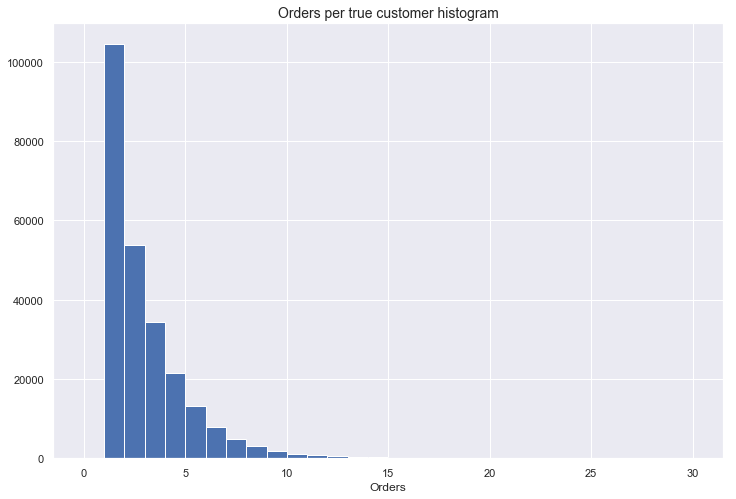

In [62]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(orders_per_customer, bins=30, range=(0, 30))
plt.xlabel('Orders')
plt.title('Orders per true customer histogram', fontsize=14)
plt.show()

In [63]:
Counter(orders_per_customer), np.percentile(orders_per_customer, 99.9)

(Counter({1: 104491,
          2: 53793,
          3: 34449,
          4: 21463,
          5: 13261,
          6: 7981,
          7: 4967,
          8: 3041,
          9: 1828,
          10: 1184,
          11: 754,
          12: 491,
          13: 357,
          14: 262,
          15: 196,
          16: 154,
          17: 86,
          18: 88,
          19: 59,
          20: 43,
          21: 40,
          22: 36,
          23: 26,
          24: 31,
          25: 16,
          26: 19,
          27: 17,
          28: 5,
          29: 15,
          30: 10,
          31: 13,
          32: 8,
          33: 8,
          34: 5,
          35: 4,
          36: 5,
          37: 1,
          38: 6,
          39: 5,
          41: 2,
          42: 3,
          43: 4,
          44: 3,
          45: 2,
          46: 1,
          47: 3,
          48: 1,
          52: 1,
          55: 1,
          58: 1,
          63: 2,
          66: 1,
          69: 1,
          71: 1,
          73: 1,
          75

#### Timedeltas between orders

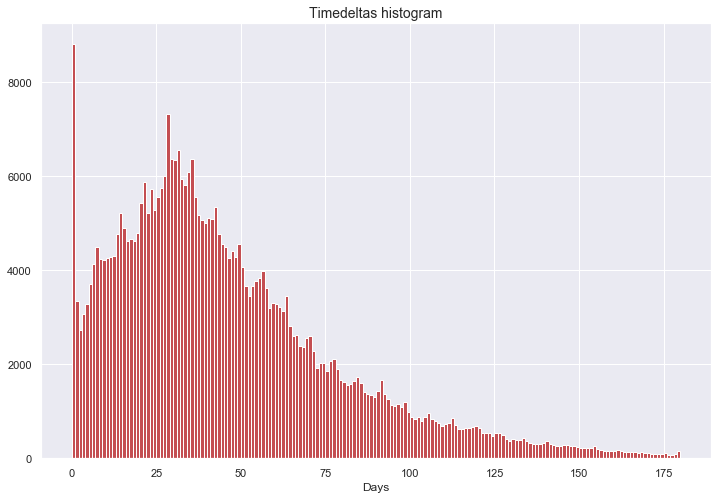

In [64]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(timedeltas_between_orders, bins=180, range=(0, 180), color='r')
plt.xlabel('Days')
plt.title('Timedeltas histogram', fontsize=14)
plt.show()

In [65]:
np.percentile(timedeltas_between_orders, 5)

4.0

#### Delivery zipcodes per true customer

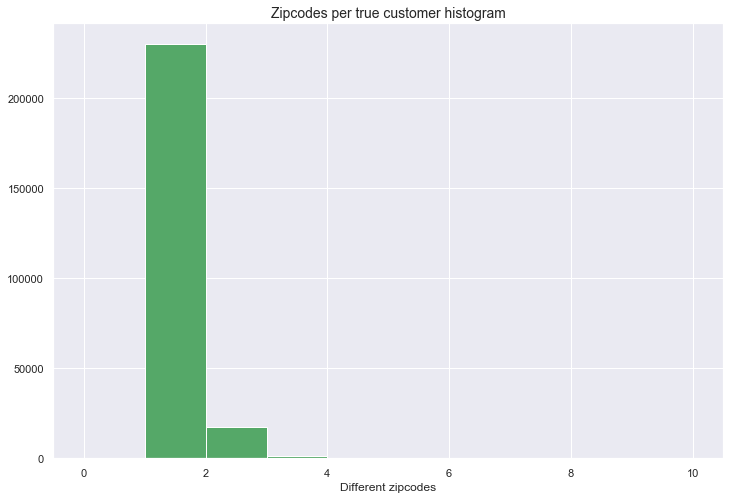

In [66]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(set_zipcodes_per_customer, bins=10, range=(0, 10), color='g')
plt.xlabel('Different zipcodes')
plt.title('Zipcodes per true customer histogram', fontsize=14)
plt.show()

In [67]:
Counter(set_zipcodes_per_customer), np.percentile(set_zipcodes_per_customer, 99.9)

(Counter({1: 230129,
          2: 17627,
          3: 1302,
          4: 145,
          5: 27,
          6: 7,
          7: 2,
          8: 2,
          9: 1,
          11: 1,
          13: 1,
          15: 1,
          25: 1,
          30: 1,
          41: 1,
          43: 1,
          160: 1,
          181: 1,
          573: 1}),
 3.0)

#### Basket Values

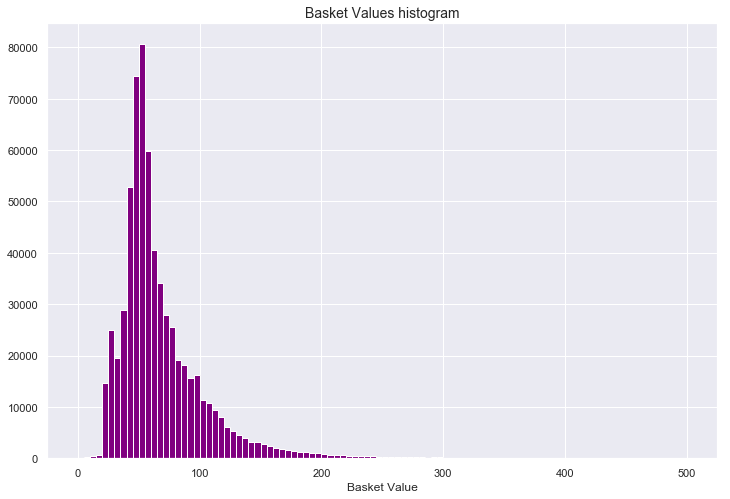

In [68]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(basket_values, bins=100, range=(0, 500), color='purple')
plt.xlabel('Basket Value')
plt.title('Basket Values histogram', fontsize=14)
plt.show()

In [69]:
np.percentile(basket_values, 99.5)

270.807200000002

#### Total sales value

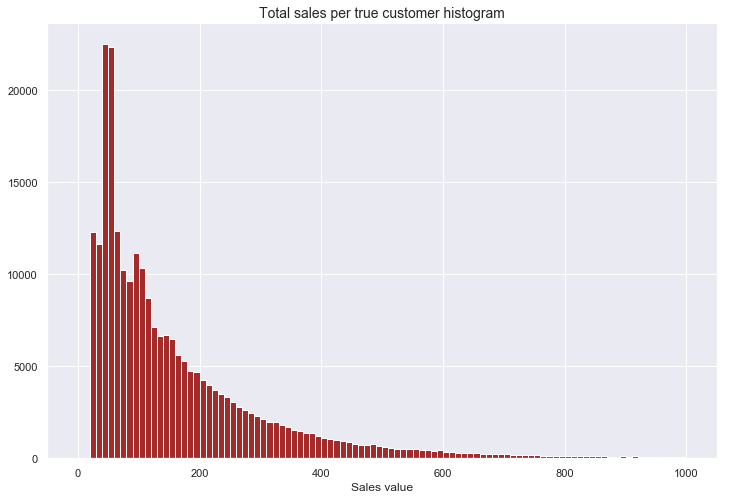

In [70]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(total_sales_values, bins=100, range=(0, 1000), color='brown')
plt.xlabel('Sales value')
plt.title('Total sales per true customer histogram', fontsize=14)
plt.show()

In [71]:
np.max(total_sales_values), np.percentile(total_sales_values, 99.9)

(39602.0, 2441.613890000144)

#### Items per order

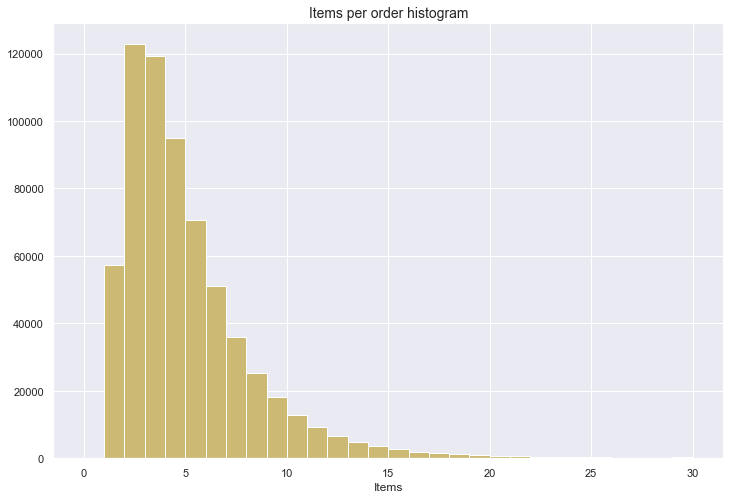

In [72]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(items_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Items')
plt.title('Items per order histogram', fontsize=14)
plt.show()

In [73]:
Counter(items_per_order), np.percentile(items_per_order, 99.9)

(Counter({1: 57315,
          2: 122788,
          3: 119274,
          4: 94975,
          5: 70711,
          6: 51065,
          7: 36021,
          8: 25375,
          9: 18096,
          10: 12899,
          11: 9383,
          12: 6528,
          13: 4849,
          14: 3582,
          15: 2668,
          16: 1998,
          17: 1519,
          18: 1199,
          19: 1010,
          20: 787,
          21: 708,
          22: 517,
          23: 440,
          24: 350,
          25: 238,
          26: 237,
          27: 194,
          28: 149,
          29: 115,
          30: 130,
          31: 112,
          32: 88,
          33: 80,
          34: 58,
          35: 54,
          36: 46,
          37: 36,
          38: 34,
          39: 34,
          40: 26,
          41: 26,
          42: 18,
          43: 16,
          44: 16,
          45: 20,
          46: 8,
          47: 16,
          48: 19,
          49: 8,
          50: 9,
          51: 7,
          52: 5,
          53: 5,

#### Order positions per order

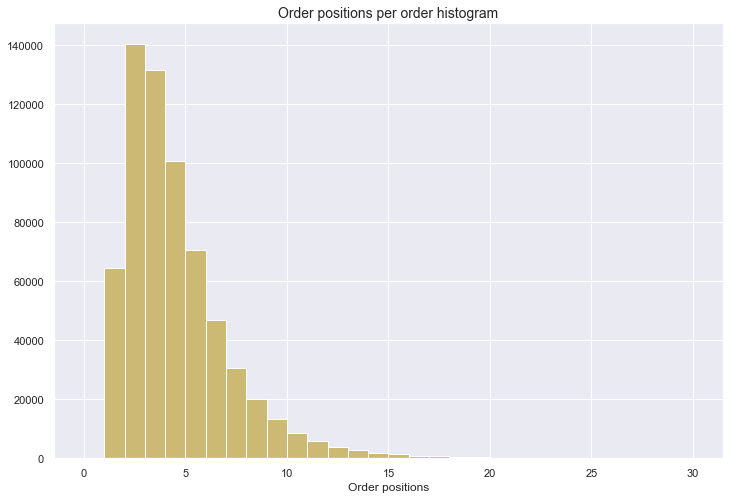

In [74]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(order_positions_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Order positions')
plt.title('Order positions per order histogram', fontsize=14)
plt.show()

In [75]:
Counter(order_positions_per_order), np.percentile(order_positions_per_order, 99.9)

(Counter({1: 64346,
          2: 140357,
          3: 131714,
          4: 100856,
          5: 70408,
          6: 46971,
          7: 30606,
          8: 20030,
          9: 13137,
          10: 8603,
          11: 5737,
          12: 3752,
          13: 2705,
          14: 1781,
          15: 1354,
          16: 895,
          17: 646,
          18: 480,
          19: 391,
          20: 227,
          21: 203,
          22: 153,
          23: 137,
          24: 73,
          25: 77,
          26: 48,
          27: 54,
          28: 42,
          29: 33,
          30: 26,
          31: 11,
          32: 15,
          33: 16,
          34: 6,
          35: 4,
          36: 5,
          37: 10,
          38: 9,
          39: 6,
          40: 11,
          41: 5,
          42: 1,
          43: 3,
          44: 2,
          45: 2,
          47: 2,
          48: 3,
          50: 1,
          51: 1,
          53: 1,
          55: 1,
          56: 2,
          60: 1,
          61: 2,
      

#### Different animals - Lead PG2- per true customer

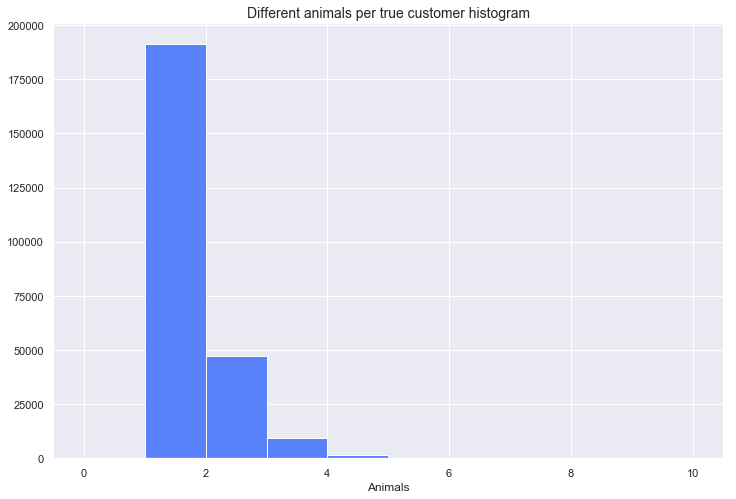

In [76]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(animals_per_customer, bins=10, range=(0, 10), color='#5882FA')
plt.xlabel('Animals')
plt.title('Different animals per true customer histogram', fontsize=14)
plt.show()

In [77]:
np.max(animals_per_customer), np.percentile(animals_per_customer, 99)

(7, 3.0)

In [78]:
Counter(animals_per_customer)

Counter({1: 191196, 2: 47005, 3: 9287, 4: 1514, 5: 212, 6: 32, 7: 6})

#### Different Lead PG3 per true customer

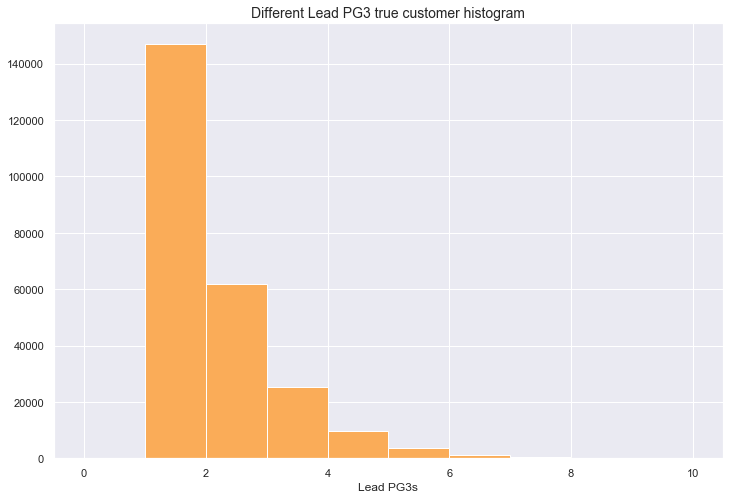

In [79]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(lead_prod_groups_3_per_customer, bins=10, range=(0, 10), color='#FAAC58')
plt.xlabel('Lead PG3s')
plt.title('Different Lead PG3 true customer histogram', fontsize=14)
plt.show()

In [80]:
np.max(lead_prod_groups_3_per_customer), np.percentile(lead_prod_groups_3_per_customer, 99.9)

(23, 8.0)

In [81]:
Counter(lead_prod_groups_3_per_customer)

Counter({1: 146900,
         2: 61877,
         3: 25261,
         4: 9532,
         5: 3494,
         6: 1343,
         7: 519,
         8: 177,
         9: 85,
         10: 23,
         11: 20,
         12: 12,
         13: 3,
         14: 2,
         15: 1,
         16: 1,
         17: 1,
         23: 1})

#### Brands -Lead PG4- per true customer

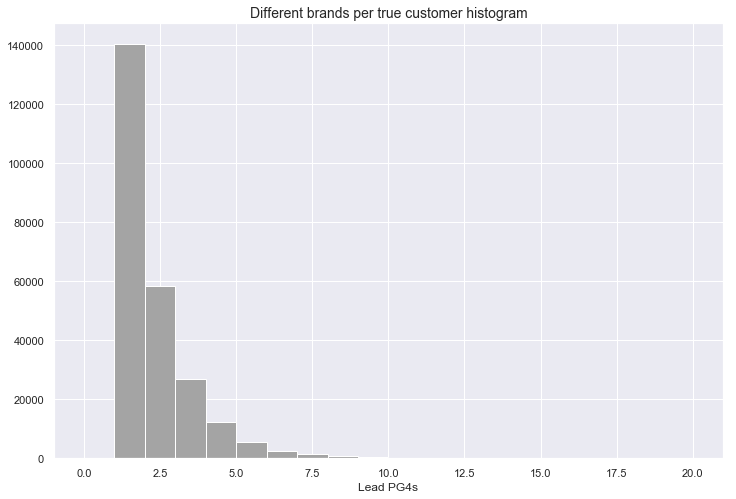

In [82]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(brands_per_customer, bins=20, range=(0, 20), color='#A4A4A4')
plt.xlabel('Lead PG4s')
plt.title('Different brands per true customer histogram', fontsize=14)
plt.show()

In [83]:
np.max(brands_per_customer), np.percentile(brands_per_customer, 99.9)

(64, 12.0)

In [84]:
Counter(brands_per_customer)

Counter({1: 140380,
         2: 58324,
         3: 27007,
         4: 12229,
         5: 5578,
         6: 2609,
         7: 1361,
         8: 696,
         9: 403,
         10: 233,
         11: 161,
         12: 79,
         13: 59,
         14: 38,
         15: 19,
         16: 16,
         17: 16,
         18: 11,
         19: 6,
         20: 2,
         21: 8,
         22: 4,
         23: 2,
         24: 1,
         25: 3,
         27: 1,
         28: 1,
         29: 2,
         36: 1,
         48: 1,
         64: 1})

#### Different lead shop articles per customer

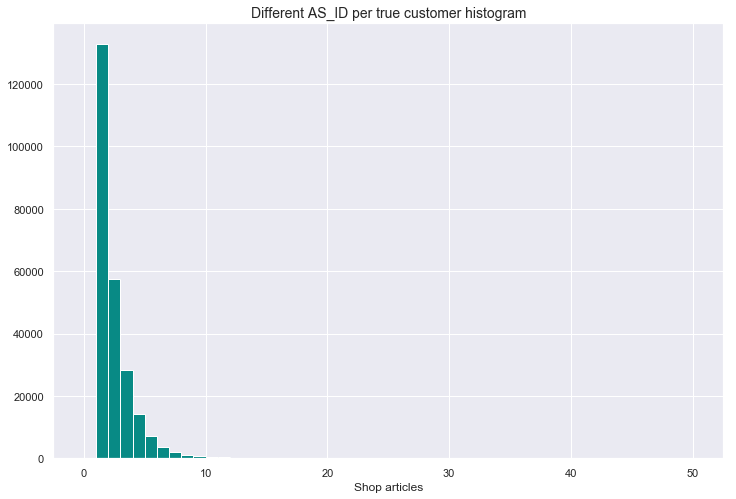

In [85]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_per_customer, bins=50, range=(0, 50), color='#088A85')
plt.xlabel('Shop articles')
plt.title('Different AS_ID per true customer histogram', fontsize=14)
plt.show()

In [86]:
Counter(arts_shop_per_customer), np.percentile(arts_shop_per_customer, 99.9)

(Counter({1: 132823,
          2: 57568,
          3: 28373,
          4: 14226,
          5: 7174,
          6: 3758,
          7: 2117,
          8: 1112,
          9: 722,
          10: 443,
          11: 278,
          12: 182,
          13: 112,
          14: 90,
          15: 47,
          16: 43,
          17: 31,
          18: 31,
          19: 16,
          20: 22,
          21: 12,
          22: 12,
          23: 13,
          24: 8,
          25: 3,
          26: 9,
          27: 5,
          28: 3,
          30: 3,
          32: 2,
          34: 1,
          35: 2,
          37: 1,
          43: 2,
          45: 1,
          47: 1,
          49: 1,
          52: 1,
          59: 1,
          62: 1,
          65: 1,
          171: 1}),
 15.0)

#### Ratio Different Lead AS_ID / Orders 

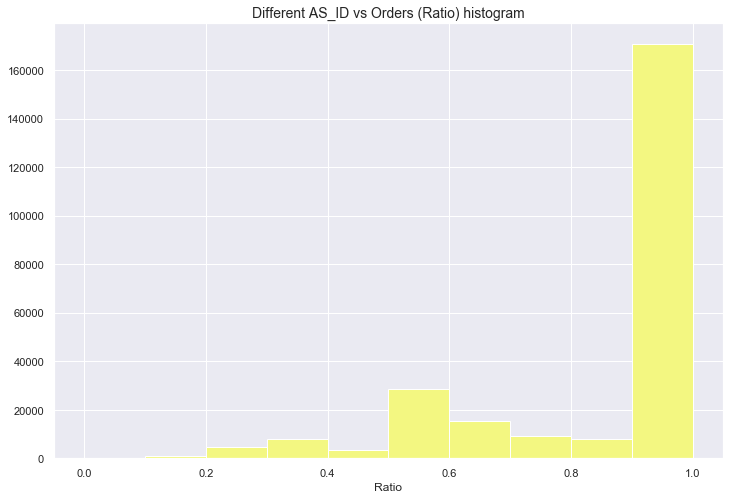

In [87]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_orders_ratio_per_customer, bins=10, range=(0, 1), color='#F3F781')
plt.xlabel('Ratio')
plt.title('Different AS_ID vs Orders (Ratio) histogram', fontsize=14)
plt.show()

In [88]:
Counter(arts_shop_orders_ratio_per_customer), np.percentile(arts_shop_orders_ratio_per_customer, 99)

(Counter({0.071: 1,
          0.077: 2,
          0.083: 2,
          0.091: 5,
          0.094: 1,
          0.1: 9,
          0.111: 48,
          0.125: 89,
          0.133: 3,
          0.143: 267,
          0.154: 7,
          0.167: 538,
          0.172: 1,
          0.178: 1,
          0.182: 15,
          0.188: 2,
          0.196: 1,
          0.2: 1183,
          0.208: 1,
          0.214: 3,
          0.217: 1,
          0.222: 64,
          0.227: 1,
          0.231: 4,
          0.24: 3,
          0.25: 2841,
          0.259: 1,
          0.263: 1,
          0.267: 1,
          0.269: 1,
          0.273: 21,
          0.278: 2,
          0.28: 1,
          0.281: 1,
          0.286: 450,
          0.292: 1,
          0.294: 3,
          0.296: 1,
          0.3: 67,
          0.308: 14,
          0.312: 6,
          0.316: 6,
          0.318: 1,
          0.32: 1,
          0.333: 7684,
          0.345: 1,
          0.353: 3,
          0.357: 8,
          0.36: 1,
         

#### Max order counter per customer

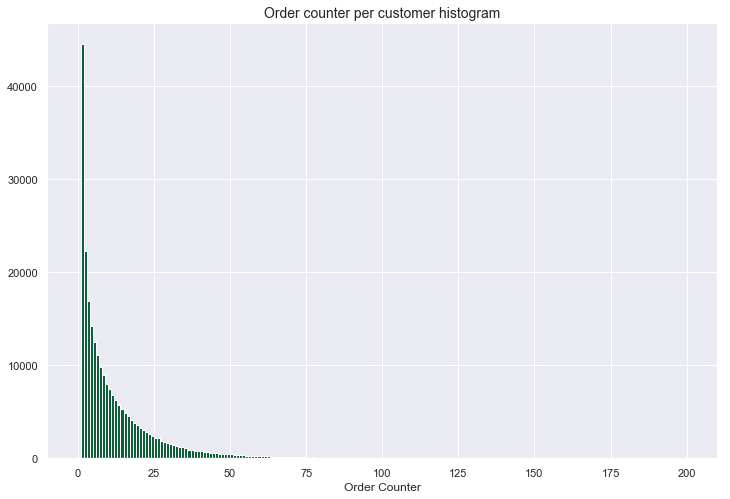

In [89]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(max_order_counter_per_customer, bins=200, range=(0, 200), color='#0B6138')
plt.xlabel('Order Counter')
plt.title('Order counter per customer histogram', fontsize=14)
plt.show()

In [90]:
Counter(max_order_counter_per_customer).most_common(), np.percentile(max_order_counter_per_customer, 99.9)

([(1, 44504),
  (2, 22229),
  (3, 16938),
  (4, 14254),
  (5, 12459),
  (6, 11118),
  (7, 9763),
  (8, 9004),
  (9, 7972),
  (10, 7448),
  (11, 6809),
  (12, 6293),
  (13, 5678),
  (14, 5296),
  (15, 4883),
  (16, 4493),
  (17, 4088),
  (18, 3814),
  (19, 3548),
  (20, 3286),
  (21, 3068),
  (22, 2827),
  (23, 2594),
  (24, 2353),
  (25, 2164),
  (26, 2130),
  (27, 1847),
  (28, 1758),
  (29, 1656),
  (30, 1575),
  (31, 1427),
  (32, 1350),
  (33, 1216),
  (34, 1205),
  (35, 1064),
  (37, 943),
  (36, 929),
  (38, 835),
  (39, 808),
  (40, 766),
  (41, 694),
  (42, 660),
  (43, 610),
  (44, 549),
  (45, 534),
  (46, 515),
  (47, 493),
  (48, 448),
  (49, 439),
  (50, 416),
  (51, 375),
  (53, 344),
  (52, 336),
  (54, 328),
  (55, 295),
  (57, 266),
  (56, 261),
  (59, 240),
  (60, 225),
  (58, 220),
  (61, 216),
  (62, 194),
  (64, 192),
  (63, 172),
  (66, 171),
  (65, 164),
  (67, 148),
  (68, 141),
  (71, 136),
  (69, 132),
  (70, 126),
  (74, 124),
  (72, 102),
  (73, 100),
  (77,

### Outlier detection based on percentiles

In [10]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum',
       'O_GWERT_list', 'DATE_N_SV_list', 'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID',
       'L4_PG_ID', 'OCI_PLZ_list', 'O_TIMEDELTAS'],
      dtype='object')

We define here the percentiles of each feature for testing just within our data...

In [11]:
features_percentiles = [np.percentile(orders_per_customer, 99.9), np.percentile(timedeltas_between_orders, 5), 
                                np.percentile(set_zipcodes_per_customer, 99.9), np.percentile(total_sales_values, 99.9), 
                                np.percentile(basket_values, 99.9), np.percentile(items_per_order, 99.9),
                                np.percentile(order_positions_per_order, 99.9),
                                np.percentile(arts_shop_per_customer, 99.9), 
                                np.rint(np.percentile(max_order_counter_per_customer, 99.9))]

In [12]:
features_percentiles

[22.0,
 4.0,
 3.0,
 2441.613890000144,
 427.69188000002646,
 32.0,
 22.0,
 15.0,
 155.0]

In [13]:
features_percentiles = pd.DataFrame([features_percentiles], columns=['ORDERS', 
                                                                'TD_PER_ORDER', 'ZIPCODES', 'TOTAL_SALES', 
                                                                'BASKET_VALUE', 'ITEMS_PER_ORDER','O_POS_PER_ORDER',
                                                                'LEAD_AS_IDs', 'ORDER_COUNTER'])

In [14]:
features_percentiles

,ORDERS,TD_PER_ORDER,ZIPCODES,TOTAL_SALES,BASKET_VALUE,ITEMS_PER_ORDER,O_POS_PER_ORDER,LEAD_AS_IDs,ORDER_COUNTER
0,22.0,4.0,3.0,2441.61389,427.69188,32.0,22.0,15.0,155.0


In [15]:
features_percentiles['TD_PER_ORDER'].values[0]

4.0

We define using a binary classification (0, 1) if the customer or one of his orders is considered as outlier for each of the features tested...

In [16]:
# Variables to check per true customer: orders, different delivery zipcodes, total sales, different lead pg2/pg3/pg4

In [17]:
customers['OUTL_ORDERS'] = [(i > features_percentiles['ORDERS'].values[0]) * 1 for i in customers['O_ID_len'].values]

In [18]:
customers['OUTL_OCI_PLZ'] = [(len(i.keys()) > features_percentiles['ZIPCODES'].values[0]) * 1 for i in customers['OCI_PLZ_list'].values]

In [19]:
customers['OUTL_TOT_O_GWERT'] = [(i > features_percentiles['TOTAL_SALES'].values[0]) * 1 for i in customers['O_GWERT_sum'].values]

In [20]:
#customers['OUTL_PG2'] = [(len(i.keys()) > features_percentiles['PG2'].values[0]) * 1 for i in customers['L2_PG_ID'].values]

In [21]:
#customers['OUTL_PG3'] = [(len(i.keys()) > features_percentiles['PG3'].values[0]) * 1 for i in customers['L3_PG_ID'].values]

In [22]:
#customers['OUTL_PG4'] = [(len(i.keys()) > features_percentiles['PG4'].values[0]) * 1 for i in customers['L4_PG_ID'].values]

In [23]:
customers['OUTL_AS_IDs'] = [(len(i.keys()) > features_percentiles['LEAD_AS_IDs'].values[0]) * 1 for i in customers['LEAD_AS_ID'].values]

In [24]:
customers['OUTL_O_COUNTER'] = [(sum(i) > features_percentiles['ORDER_COUNTER'].values[0]) * 1 for i in customers['O_K_COUNTER_MAX_list'].values]

In [25]:
# Variables to check per order belonging to the customer: timedeltas between orders, basket values, items per order

In [26]:
# For this variable let's start with the percentile 5 (4 days timedelta) instead of percentile 2.5 (1 day)
customers['OUTL_TIMEDELTAS'] = [[(j < features_percentiles['TD_PER_ORDER'].values[0]) * 1 if len(i) >= 1 else i for j in i]
                                    for i in customers['O_TIMEDELTAS'].values]

In [27]:
customers['OUTL_BASKET_VALUES'] = [[(j > features_percentiles['BASKET_VALUE'].values[0]) * 1 for j in i]
                                for i in customers['O_GWERT_list'].values]

In [28]:
customers['OUTL_ITEMS'] = [[(sum(j) > features_percentiles['ITEMS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AMOUNT_list'].values]

In [29]:
customers['OUTL_O_POS'] = [[(j > features_percentiles['O_POS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AS_ID_len_list'].values]

In [30]:
# For last three variables let's compute the relevance of outliers within their all orders

In [31]:
customers['OUTL_TD_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_TIMEDELTAS'].values]

In [32]:
customers['OUTL_BV_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_BASKET_VALUES'].values]

In [33]:
customers['OUTL_ITEMS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_ITEMS'].values]

In [34]:
customers['OUTL_O_POS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_O_POS'].values]

In [35]:
customers['OCI_PLZ_len'] = customers['OCI_PLZ_list'].apply(len)

In [36]:
customers['LEAD_AS_ID_len'] = customers['LEAD_AS_ID'].apply(len)

In [37]:
customers['MAX_O_COUNTER'] = customers['O_K_COUNTER_MAX_list'].apply(sum)

In [38]:
customers['DIFF_ZIP_PERC'] = np.round(customers['OCI_PLZ_len'] / customers['O_ID_len'], 3)

### Identify blacklist profiles using outlier detection

+ Dropshippers
+ High basket value customers
+ High frequency customers

**Dropshippers**: 

Several delivery zipcodes and must match also one of the hard criteria: being an outlier in terms of amount of orders, total sales value or order counter

In [39]:
dropshippers = list(customers[(customers['OUTL_OCI_PLZ'] == 1) & ((customers['OUTL_ORDERS'] == 1) |
                                              (customers['OUTL_TOT_O_GWERT'] == 1) |
                                              (customers['OUTL_O_COUNTER'] == 1)
                                             ) & (customers['DIFF_ZIP_PERC'] >= 0.3)]['TC_ID'].values)

In [40]:
len(dropshippers)

10

In [41]:
#Dropshippers early detection using other features: different lead as_id or outlier TD%
customers[(customers['OUTL_OCI_PLZ'] == 1) & (~customers['TC_ID'].isin(dropshippers)) & (customers['DIFF_ZIP_PERC'] >= 0.3) &
          ((customers['OUTL_AS_IDs'] == 1) |
          (customers['OUTL_TD_%'] >= 0.5) 
            )]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
24998,2637634,11,"[2018-05-11 15:16:26, 2018-06-05 16:46:57, 201...",[1462089],"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]",[22],779.56,"[69.76, 69.8, 114.42, 57.21, 57.21, 53.32, 71....","[(2018-05-11 15:16:26, 69.76), (2018-06-05 16:...","[[38534, 38635, 42715], [42715, 12037, 69102, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.0,0.0,0.0,11,8,22,1.000
25005,2638667,9,"[2018-05-30 13:06:21, 2018-08-07 13:25:12, 201...",[3022099],"[55, 56, 57, 58, 59, 60, 61, 62, 63]",[63],538.72,"[62.06, 54.31, 48.96, 92.1, 68.36, 57.21, 48.4...","[(2018-05-30 13:06:21, 62.06), (2018-08-07 13:...","[[24438, 11141, 42715], [79244, 6169, 11141, 4...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.0,0.0,0.0,4,7,63,0.444
46191,5232524,5,"[2018-06-05 12:16:10, 2018-09-21 10:52:28, 201...",[6359802],"[39, 40, 41, 42, 43]",[43],894.08,"[110.96, 170.94, 156.95, 81.95, 373.28]","[(2018-06-05 12:16:10, 110.96), (2018-09-21 10...","[[24746, 68054, 23968, 65052, 75282], [52632, ...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.5,0.0,0.0,0.0,4,5,43,0.800
176920,14053225,9,"[2018-05-29 10:03:45, 2018-08-06 15:02:04, 201...",[19223812],"[4, 5, 6, 7, 8, 9, 10, 11, 12]",[12],905.49,"[137.7, 116.81, 123.46, 38.94, 39.92, 109.35, ...","[(2018-05-29 10:03:45, 137.7), (2018-08-06 15:...","[[70996, 68468, 65470, 68383, 57796, 42715], [...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.0,0.0,0.0,4,5,12,0.444


**High basket value customers**

Customers labeled as outliers by their total sales value but not because of the orders and of course not included in the previous group (now the outlier value in delivery zipcodes is forced to be 0)

In [42]:
high_basket_customers = list(customers[(customers['OUTL_TOT_O_GWERT'] == 1) & (customers['OUTL_ORDERS'] == 0) &
         (~customers['TC_ID'].isin(dropshippers))]['TC_ID'].values)

In [43]:
len(high_basket_customers)

129

In [44]:
customers[customers['TC_ID'].isin(high_basket_customers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
43,1020,20,"[2018-05-11 11:31:29, 2018-05-30 10:46:06, 201...",[1827682],"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[99],2454.05,"[105.84, 128.86, 103.83, 94.83, 109.86, 111.85...","[(2018-05-11 11:31:29, 105.84), (2018-05-30 10...","[[6168, 73457, 70087, 73457], [61248, 70088, 6...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.211,0.000,0.000,0.000,1,11,99,0.050
978,24196,7,"[2018-05-16 17:12:17, 2018-06-08 10:43:53, 201...",[8245091],"[112, 113, 114, 115, 116, 117, 118]",[118],3621.07,"[869.23, 143.97, 563.42, 724.23, 600.95, 177.7...","[(2018-05-16 17:12:17, 869.23), (2018-06-08 10...","[[57804, 46119, 61298, 5482, 61248, 64088, 708...",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0.000,0.714,0.000,0.000,1,6,118,0.143
1143,28430,5,"[2018-08-07 16:55:11, 2018-08-24 11:50:57, 201...",[6834115],"[135, 137, 141, 145, 151]",[151],3193.60,"[1739.03, 61.74, 651.6, 610.77, 130.46]","[(2018-08-07 16:55:11, 1739.03), (2018-08-24 1...","[[13685, 7883, 7992, 57311, 21060, 21061, 2106...",...,"[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.000,0.600,0.200,0.000,2,3,151,0.400
1629,40523,22,"[2018-05-02 10:44:36, 2018-05-13 20:49:19, 201...",[1942017],"[178, 179, 180, 181, 182, 183, 184, 185, 186, ...",[199],7209.07,"[312.17, 224.91, 385.99, 296.73, 163.78, 387.7...","[(2018-05-02 10:44:36, 312.17), (2018-05-13 20...","[[79003, 61197, 50230, 75525, 5482], [67426, 5...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.048,0.318,0.000,0.000,1,7,199,0.045
2816,67712,10,"[2018-05-18 00:49:21, 2018-07-28 13:04:35, 201...",[16756234],"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",[15],4273.71,"[1542.27, 584.38, 111.43, 56.51, 769.61, 299.6...","[(2018-05-18 00:49:21, 1542.27), (2018-07-28 1...","[[50305, 57308, 75281, 40928, 25360, 32417, 56...",...,"[1, 1, 0, 0, 1, 0, 1, 0, 1, 0]","[1, 1, 0, 0, 1, 0, 0, 0, 1, 0]",0.333,0.400,0.500,0.400,1,8,15,0.100
2883,69151,16,"[2018-05-04 13:57:14, 2018-05-12 11:20:32, 201...","[10999231, 15135617]","[41, 42, 43, 44, 45, 47, 49, 48, 49, 50, 51, 5...","[51, 8]",2497.12,"[157.06, 123.15, 283.6, 226.42, 239.07, 69.8, ...","[(2018-05-04 13:57:14, 157.06), (2018-05-12 11...","[[20139, 64153, 72476, 64211, 68059, 42715], [...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.067,0.000,0.000,0.000,1,13,59,0.062
3858,93480,9,"[2018-05-11 19:59:05, 2018-06-03 20:52:48, 201...",[19097428],"[6, 7, 8, 9, 10, 11, 12, 13, 14]",[14],3017.71,"[499.08, 272.56, 753.86, 334.34, 63.24, 737.25...","[(2018-05-11 19:59:05, 499.08), (2018-06-03 20...","[[38535, 16618, 55526, 68349, 67937, 28051, 70...",...,"[0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.125,0.333,0.111,0.000,1,6,14,0.111
4786,115811,11,"[2018-05-07 20:27:40, 2018-06-13 12:12:48, 201...",[2404110],"[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]",[75],3156.11,"[518.59, 387.49, 320.07, 72.18, 139.62, 161.49...","[(2018-05-07 20:27:40, 518.59), (2018-06-13 12...","[[42715, 37451, 62930, 73545], [37451, 62930, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000,0.091,0.000,0.000,1,5,75,0.091
5421,133298,15,"[2018-05-14 10:18:16, 2018-06-08 11:12:24, 201...",[7097585],"[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6...",[71],2479.66,"[389.13, 72.7, 181.34, 100.87, 104.74, 379.69,...","[(2018-05-14 10:18:16, 389.13), (2018-06-08 11...","[[69848, 32585, 68059, 70547, 6169, 50341, 694...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.071,0.000,0.000,0.000,1,9,71,0.067
5456,134710,14,"[2018-05-23 13:05:28, 2018-06-22 09:37:28, 201...

In [45]:
# Early detection of high basket value customers 
customers[(~customers['TC_ID'].isin(dropshippers)) & (~customers['TC_ID'].isin(high_basket_customers)) &
          (customers['OUTL_BV_%'] >= 0.5) & (customers['O_ID_len'] >= 3)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
3137,74894,3,"[2018-05-14 21:38:42, 2018-06-20 21:57:34, 201...",[2544823],"[263, 264, 265]",[265],1255.76,"[582.92, 514.9, 157.94]","[(2018-05-14 21:38:42, 582.92), (2018-06-20 21...","[[52564, 6169, 67368, 69391, 69837, 6168], [65...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,2,265,0.333
6339,162234,3,"[2018-05-16 15:47:09, 2018-08-14 21:54:18, 201...",[3254670],"[32, 33, 34]",[34],1366.84,"[468.29, 221.3, 677.25]","[(2018-05-16 15:47:09, 468.29), (2018-08-14 21...","[[66380, 61217, 61114, 67044, 26938, 42715], [...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,2,34,0.333
29568,3208076,3,"[2018-05-28 12:45:42, 2018-08-02 11:33:54, 201...",[3733142],"[67, 68, 69]",[69],1158.64,"[430.35, 297.73, 430.56]","[(2018-05-28 12:45:42, 430.35), (2018-08-02 11...","[[78246, 52443, 6169, 52442, 50129, 28168, 782...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,69,0.333
43520,4885041,3,"[2018-07-09 21:32:07, 2018-09-23 14:02:18, 201...",[5906288],"[41, 42, 43]",[43],1284.33,"[551.83, 277.63, 454.87]","[(2018-07-09 21:32:07, 551.83), (2018-09-23 14...","[[61280, 59841, 67358, 55118, 50230, 61197, 73...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,43,0.333
54867,6109222,3,"[2018-06-05 12:08:25, 2018-08-20 11:59:56, 201...",[7509985],"[8, 9, 10]",[10],1359.57,"[483.91, 331.63, 544.03]","[(2018-06-05 12:08:25, 483.91), (2018-08-20 11...","[[75105, 75911, 70923, 71003, 68415, 66281, 42...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,1,10,0.333
59034,6503246,4,"[2018-05-18 18:48:34, 2018-07-11 01:25:01, 201...",[8030510],"[56, 57, 59, 60]",[60],2105.28,"[660.66, 668.39, 743.77, 32.46]","[(2018-05-18 18:48:34, 660.66), (2018-07-11 01...","[[50341, 68967, 67368, 62595, 67015, 50343, 74...",...,"[1, 1, 1, 0]","[0, 0, 0, 0]",0.000,0.750,0.750,0.000,1,4,60,0.250
62115,6769880,3,"[2018-05-15 10:42:27, 2018-08-12 10:01:42, 201...",[8419756],"[27, 28, 29]",[29],1436.07,"[705.97, 249.28, 480.82]","[(2018-05-15 10:42:27, 705.97), (2018-08-12 10...","[[11141, 71551, 68571, 11141, 18131, 61142, 70...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,29,0.333
65170,7015211,3,"[2018-06-07 21:33:51, 2018-08-20 21:57:06, 201...",[8767626],"[13, 14, 15]",[15],1226.59,"[429.7, 495.95, 300.94]","[(2018-06-07 21:33:51, 429.7), (2018-08-20 21:...","[[34058, 21449, 62817, 28167, 61109, 69573, 28...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,15,0.333
70881,7440206,3,"[2018-05-01 19:30:04, 2018-06-04 19:41:21, 201...",[9382122],"[16, 18, 19]",[19],1197.27,"[493.88, 520.93, 182.46]","[(2018-05-01 19:30:04, 493.88), (2018-06-04 19...","[[5482, 70936, 68423, 59844, 73732, 76476, 616...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,19,0.333
88865,8862647,3,"[2018-06-20 19:10:07, 2018-08-19 11:58:53, 201...",[11498809],"[29, 30, 31]",[31],1299.37,"[378.99, 458.75, 461.63]","[(2018-06-20 19:10:07, 378.99), (2018-08-19 11...","[[32971, 32446, 32970, 32972, 42715], [32446, ...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,1,31,0.333


**High frequency/activity customers**

Customers not belonging to the dropshippers group having been labeled as outliers because of their orders (amount) and also requesting the outlier label in either, total sales value or max_order_counter

In [46]:
high_activity_customers = list(customers[(customers['OUTL_ORDERS'] == 1) & (~customers['TC_ID'].isin(dropshippers)) &
          ((customers['OUTL_TOT_O_GWERT'] == 1) |
         (customers['OUTL_O_COUNTER'] == 1))]['TC_ID'].values)

In [47]:
len(high_activity_customers)

133

In [48]:
customers[customers['TC_ID'].isin(high_activity_customers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
255,5807,43,"[2018-05-01 09:46:14, 2018-05-03 14:32:20, 201...",[1613142],"[648, 649, 650, 651, 652, 653, 654, 655, 656, ...",[690],3129.17,"[93.96, 84.97, 48.72, 65.03, 46.31, 72.18, 95....","[(2018-05-01 09:46:14, 93.96), (2018-05-03 14:...","[[55877, 65584, 6169, 68059, 42715], [6169, 55...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.333,0.000,0.000,0.0,1,27,690,0.023
460,10787,47,"[2018-05-08 18:43:59, 2018-05-23 08:32:36, 201...",[7210487],"[180, 181, 182, 183, 184, 185, 186, 187, 188, ...",[226],3023.91,"[64.96, 55.25, 61.08, 64.47, 94.02, 55.26, 94....","[(2018-05-08 18:43:59, 64.96), (2018-05-23 08:...","[[6169, 61348, 64678, 64106, 42715], [6169, 28...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.500,0.000,0.000,0.0,1,23,226,0.021
478,11287,24,"[2018-05-10 13:28:51, 2018-05-22 11:12:49, 201...",[15383808],"[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5...",[67],2499.85,"[132.97, 52.89, 128.97, 48.89, 175.96, 55.89, ...","[(2018-05-10 13:28:51, 132.97), (2018-05-22 11...","[[61093, 64656, 32605, 23378, 50892], [61043, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.130,0.000,0.000,0.0,1,12,67,0.042
1207,30101,63,"[2018-05-03 19:18:23, 2018-05-10 10:49:08, 201...",[13009491],"[117, 118, 119, 120, 121, 122, 123, 124, 125, ...",[179],8839.88,"[97.75, 297.25, 112.99, 152.85, 192.59, 128.48...","[(2018-05-03 19:18:23, 97.75), (2018-05-10 10:...","[[61172, 61177, 61053, 42715], [64056, 67363, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.581,0.000,0.048,0.0,1,37,179,0.016
1325,32780,26,"[2018-05-05 23:40:48, 2018-05-10 12:52:16, 201...",[9289266],"[153, 154, 155, 156, 157, 159, 160, 161, 161, ...",[178],5728.28,"[170.91, 250.67, 68.36, 170.94, 170.9, 311.44,...","[(2018-05-05 23:40:48, 170.91), (2018-05-10 12...","[[67678, 67736, 64798, 42715], [67736, 64738, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.320,0.038,0.000,0.0,1,18,178,0.038
1388,34434,170,"[2018-05-02 12:55:23, 2018-05-02 13:07:39, 201...","[9700383, 20112927]","[287, 288, 289, 290, 291, 1, 2, 6, 4, 5, 7, 8,...","[291, 165]",24400.17,"[210.69, 54.99, 59.99, 53.95, 53.95, 95.64, 21...","[(2018-05-02 12:55:23, 95.64), (2018-05-02 13:...","[[34191, 61191, 66842, 75031, 72974, 25246, 73...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.911,0.000,0.006,0.0,2,65,456,0.012
1392,34501,45,"[2018-05-05 10:32:34, 2018-05-05 10:38:25, 201...",[9963286],"[216, 217, 218, 219, 220, 221, 222, 223, 224, ...",[260],3259.35,"[77.15, 45.56, 64.07, 46.53, 53.32, 85.78, 45....","[(2018-05-05 10:32:34, 77.15), (2018-05-05 10:...","[[63110, 64709, 6169, 70842, 73732, 42715], [4...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.386,0.000,0.000,0.0,2,19,260,0.044
1493,37209,39,"[2018-05-04 09:37:57, 2018-05-10 09:28:27, 201...",[9542583],"[152, 153, 154, 155, 156, 157, 158, 159, 160, ...",[190],2784.13,"[99.5, 72.18, 102.68, 80.71, 40.84, 54.14, 95....","[(2018-05-04 09:37:57, 99.5), (2018-05-10 09:2...","[[74321, 69135, 61056, 55077, 55500, 42715], [...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.368,0.000,0.000,0.0,1,18,190,0.026
1580,39505,42,"[2018-05-13 21:56:31, 2018-05-14 21:32:45, 201...",[8990855],"[102, 103, 104, 105, 106, 107, 108, 109, 110, ...",[143],3441.34,"[56.92, 82.93, 151.89, 99.22, 5

In [49]:
#Early detection using timedeltas...
customers[(customers['OUTL_ORDERS'] == 0) & (customers['OUTL_TD_%'] >= 0.5) & (customers['O_ID_len'] >= 5)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
319,7416,9,"[2018-05-30 14:36:37, 2018-08-09 01:04:09, 201...",[5178584],"[105, 108, 109, 110, 111, 112, 113, 114, 115]",[115],2401.41,"[284.07, 496.71, 63.58, 443.06, 357.01, 53.16,...","[(2018-05-30 14:36:37, 284.07), (2018-08-09 01...","[[63025, 50302, 25124, 79505, 62836, 79608, 62...",...,"[0, 1, 0, 1, 1, 0, 0, 0, 1]","[1, 1, 0, 1, 1, 0, 0, 0, 1]",0.500,0.333,0.444,0.556,1,7,115,0.111
1337,32988,9,"[2018-06-25 20:06:18, 2018-06-25 20:11:40, 201...",[18405305],"[9, 10, 11, 12, 13, 14, 15, 16, 17]",[17],555.81,"[49.41, 52.96, 62.13, 61.89, 58.94, 97.42, 50....","[(2018-06-25 20:06:18, 49.41), (2018-06-25 20:...","[[26950, 26951, 61195, 78405, 24920], [63616, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.500,0.000,0.000,0.000,1,8,17,0.111
1603,39990,11,"[2018-07-05 23:10:28, 2018-07-30 14:11:24, 201...",[13011006],"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]",[23],808.62,"[186.16, 144.55, 51.99, 51.99, 51.99, 51.99, 5...","[(2018-07-05 23:10:28, 186.16), (2018-07-30 14...","[[54350, 61109, 6169], [79412, 34191, 28167, 8...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.500,0.000,0.000,0.000,1,5,23,0.091
1793,44131,6,"[2018-05-16 15:07:22, 2018-05-18 09:12:04, 201...",[2003635],"[82, 83, 84, 85, 86, 87]",[87],519.34,"[139.66, 70.19, 67.78, 67.78, 81.4, 92.53]","[(2018-05-16 15:07:22, 139.66), (2018-05-18 09...","[[6169, 67874, 42715], [68369, 68446, 68366, 6...",...,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.800,0.000,0.000,0.000,2,5,87,0.333
2434,58913,5,"[2018-07-11 12:53:56, 2018-07-11 12:59:16, 201...",[16825265],"[10, 11, 12, 13, 14]",[14],391.25,"[60.98, 31.96, 87.96, 152.2, 58.15]","[(2018-07-11 12:53:56, 60.98), (2018-07-11 12:...","[[77920, 67376], [6168, 67832, 67360], [75198,...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.750,0.000,0.000,0.000,1,5,14,0.200
3240,77409,9,"[2018-06-29 09:39:25, 2018-08-09 19:37:45, 201...",[8733947],"[39, 40, 41, 42, 43, 44, 45, 46, 47]",[47],763.82,"[169.03, 47.58, 47.58, 83.71, 72.18, 72.18, 55...","[(2018-06-29 09:39:25, 169.03), (2018-08-09 19...","[[42715, 77920, 61248, 59841], [38562, 6168, 4...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.500,0.000,0.000,0.000,2,5,47,0.222
4386,107411,5,"[2018-06-02 01:35:20, 2018-08-11 19:21:37, 201...",[14407426],"[16, 17, 18, 19, 20]",[20],394.49,"[38.68, 170.68, 61.28, 69.9, 53.95]","[(2018-06-02 01:35:20, 38.68), (2018-08-11 19:...","[[6169, 35485, 68465], [78806, 76003, 70568, 7...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.000,0.000,0.000,1,5,20,0.200
4621,112661,5,"[2018-05-23 21:12:58, 2018-08-09 13:14:05, 201...",[6004131],"[14, 15, 16, 18, 19]",[19],666.88,"[105.98, 156.97, 303.95, 49.99, 49.99]","[(2018-05-23 21:12:58, 105.98), (2018-08-09 13...","[[68571], [68571, 80730, 80730], [68571, 69132...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.000,0.000,0.000,1,3,19,0.200
4847,116665,6,"[2018-07-20 12:52:55, 2018-07-20 12:54:43, 201...",[14590899],"[14, 15, 16, 17, 18, 19]",[19],324.74,"[50.39, 50.39, 55.99, 55.99, 55.99, 55.99]","[(2018-07-20 12:52:55, 50.39), (2018-07-20 12:...","[[11141, 6169], [11141, 6169], [11141], [11141...",...,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.600,0.000,0.000,0.000,1,1,19,0.167
5598,139140,11,"[2018-05-31 00:00:35, 2018-05-31 00:05:42, 201...",[16751278],"[13, 14, 15, 16, 17, 19, 20, 21, 22, 22, 23]",[23],803.50,"[93.15, 49.4, 57.79, 51.58, 141.52, 98.92, 49....","[(2018-05-31 00:00:35, 93.15), (2018-05-31 00:...","[[60987, 68971, 49242, 69103, 69101, 68059, 77...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.500,0.000,0.000,0.000,2,9,23,0.182


In [50]:
len(dropshippers), len(high_basket_customers), len(high_activity_customers)

(10, 129, 133)

In [51]:
#Check we have no duplicates TC IDs within the groups
sum([i in high_activity_customers for i in high_basket_customers])

0

In [52]:
sum([i in high_basket_customers for i in high_activity_customers])

0

In [53]:
len(set(dropshippers + high_basket_customers + high_activity_customers))

272

In [54]:
len(customers)

249252

In [55]:
outliers = dropshippers + high_basket_customers + high_activity_customers

Now we will label every customer belonging to the previously defined groups as 'blacklisted' (1)

In [56]:
customers['BLACKLIST'] = customers['TC_ID'].isin(outliers) * 1

### Check resellers list provided by SMA

In [147]:
resellers_checklist = pd.read_csv('Blacklist_Reseller.csv')

In [148]:
checklist_resellers = list(resellers_checklist['k_id'].values)

In [149]:
len(checklist_resellers)

267

In [150]:
customers.head()

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
0,119,3,"[2018-05-07 22:56:48, 2018-08-12 14:08:29, 201...",[3430986],"[6, 7, 8]",[8],96.90,"[29.97, 29.97, 36.96]","[[70742, 6168], [70742, 6168], [9795, 70742, 7...","[2, 2, 4]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",0.000,0.0,0.0,0.0,0.0,0,0
1,144,1,[2018-09-14 17:17:32],[17546766],[4],[4],81.99,[81.99],[[57800]],[1],...,[0],[0],[0],0.000,0.0,0.0,0.0,0.0,0,0
2,146,1,[2018-06-04 23:49:59],[16330511],[12],[12],71.19,[71.19],"[[68445, 27543, 68325, 62906, 42715]]",[5],...,[0],[0],[0],0.000,0.0,0.0,0.0,0.0,0,0
3,226,8,"[2018-05-12 09:56:23, 2018-05-23 12:32:57, 201...",[5652334],"[54, 55, 56, 57, 58, 59, 60, 61]",[61],468.16,"[79.52, 28.23, 77.58, 40.78, 28.23, 83.39, 48....","[[28168, 68165, 42715], [25466, 9795, 9795, 25...","[3, 6, 3, 3, 3, 6, 3, 4]",...,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0.143,0.0,0.0,0.0,0.0,0,0
4,244,7,"[2018-05-18 19:53:44, 2018-06-04 12:42:48, 201...",[17181250],"[9, 10, 11, 12, 13, 14, 15]",[15],451.81,"[72.71, 39.13, 61.47, 87.84, 52.55, 58.04, 80.07]","[[66379, 78406, 33327, 78405, 6169, 4706, 7082...","[9, 5, 4, 6, 8, 7, 9]",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0.000,0.0,0.0,0.0,0.0,0,0


In [151]:
customers['K_ID_IN_CHECKLIST'] = [any([j in checklist_resellers for j in i]) * 1 for i in customers['O_K_ID_list'].values]

In [152]:
customers['K_ID_IN_CHECKLIST'].value_counts()

0    249241
1        11
Name: K_ID_IN_CHECKLIST, dtype: int64

11 true customer IDs matching with the IDs in the list provided...here they are.

In [153]:
customers[customers['K_ID_IN_CHECKLIST'] == 1]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST
268,6254,1,[2018-05-22 14:03:26],[12014978],[616],[616],46.49,[46.49],"[[26599, 42715]]",[2],...,[0],[0],0.000,0.000,0.000,0.000,1.0,1,0,1
335,7799,293,"[2018-05-01 06:30:12, 2018-05-01 09:38:53, 201...",[17667361],"[3282, 3283, 3284, 3285, 3286, 3287, 3288, 328...",[3575],37345.66,"[118.99, 58.98, 58.98, 58.98, 59.16, 59.16, 98...","[[69631], [68056, 6168], [68054, 6168], [69573...","[1, 2, 2, 2, 3, 3, 1, 1, 1, 1, 3, 2, 2, 2, 2, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.952,0.041,0.000,0.000,6.0,1,0,1
1388,34434,170,"[2018-05-02 12:55:23, 2018-05-02 13:07:39, 201...","[9700383, 20112927]","[287, 288, 289, 290, 291, 1, 2, 6, 4, 5, 7, 8,...","[291, 165]",24400.17,"[210.69, 54.99, 59.99, 53.95, 53.95, 95.64, 21...","[[34191, 61191, 66842, 75031, 72974, 25246, 73...","[9, 2, 10, 3, 3, 2, 8, 4, 6, 3, 4, 4, 7, 8, 5,...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.911,0.024,0.006,0.000,5.0,1,0,1
8964,233995,38,"[2018-05-04 12:20:31, 2018-05-08 19:27:19, 201...",[3351945],"[183, 184, 185, 186, 188, 188, 189, 190, 191, ...",[220],11188.85,"[1168.37, 135.8, 257.39, 349.21, 44.64, 528.29...","[[68166, 64673, 75089, 64613, 52638, 61146, 45...","[25, 5, 5, 12, 2, 9, 17, 1, 2, 11, 2, 4, 10, 1...",...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.351,0.447,0.053,0.026,5.0,1,0,1
11131,293046,27,"[2018-05-13 16:36:56, 2018-05-18 14:18:33, 201...",[1874575],"[249, 250, 251, 252, 253, 254, 255, 256, 257, ...",[275],6927.12,"[359.01, 240.58, 390.31, 337.41, 259.03, 291.9...","[[2502, 64678, 57796, 39104, 55406, 57799, 647...","[13, 10, 12, 13, 8, 10, 9, 10, 8, 8, 5, 8, 7, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.115,0.444,0.000,0.000,4.0,1,0,1
11944,314497,39,"[2018-05-05 20:03:05, 2018-05-07 22:51:55, 201...",[2565850],"[353, 354, 355, 356, 357, 358, 360, 361, 362, ...",[397],12270.09,"[156.51, 136.71, 260.21, 100.75, 758.47, 137.6...","[[69856, 75192, 5482, 75289, 26317, 67378, 294...","[10, 7, 20, 5, 61, 12, 15, 7, 7, 29, 10, 42, 5...",...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",0.421,0.333,0.282,0.385,5.0,1,0,1
13535,359726,46,"[2018-05-02 12:26:55, 2018-05-05 12:39:19, 201...",[18895132],"[30, 32, 33, 34, 34, 35, 36, 37, 38, 39, 40, 4...",[75],5518.63,"[176.61, 123.46, 95.89, 175.03, 256.39, 106.33...","[[73457, 73458, 73458, 73219, 42715], [69044, ...","[5, 4, 6, 5, 5, 6, 4, 7, 4, 6, 5, 4, 4, 5, 3, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.511,0.000,0.000,0.000,4.0,1,0,1
55421,6156199,10,"[2018-07-08 22:25:24, 2018-07-22 22:19:21, 201...",[8576997],"[202, 203, 205, 206, 208, 209, 210, 213, 214, ...",[215],3757.26,"[41.98, 377.94, 628.96, 69.99, 523.7, 361.66, ...","[[22220, 6168], [30682, 64028, 5482, 81518], [...","[2, 4, 6, 1, 6, 11, 9, 5, 5, 12]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000,0.800,0.100,0.000,3.0,1,0,1
59034,6503246,4,"[2018-05-18 18:48:34, 2018-07-11 01:25:01, 201...",[8030510],"[56, 57, 59, 60]",[60],2105.28,"[660.66, 668.39, 743.77, 32.46]","[[50341, 68967, 67368, 62595, 67015, 50343, 74...","[20, 12, 18, 3]",...,"[1, 1, 1, 0]","[0, 0, 0, 0]",0.000,0.750,0.750,0.000,2.0,0,0,1
140740,12079816,2,"[2018-07-16 08:41:06, 2018-09-13 19:25:16]",[16338794],"[4, 4]",[4],180.67,"[93.75, 86.92]","[[68467, 65558, 68470, 17065], [68470, 75373, ...","[4, 6]",...,"[0, 0]","[0, 0]",0.000,0.000,0.000,0.000,0.0,0,0,1


From the list provided let's extract from Oracle the registration site ID for those customer IDs...

In [154]:
res_list = repr(checklist_resellers).replace('[','(').replace(']',')')

In [155]:
query = """select k_id, k_registration_s_id from ZOOMAN.KUNDEN
where k_id in %s""" % res_list

In [156]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
reseller_df = pd.read_sql(query, con = conn)
conn.close()

In [157]:
# Impressive Romania (site ID 24)
reseller_df['K_REGISTRATION_S_ID'].value_counts()

1      92
8      67
12     21
7      17
15     13
24     13
3      11
4       8
16      6
18      3
14      3
20      3
21      2
25      2
31      1
19      1
29      1
30      1
2       1
101     1
Name: K_REGISTRATION_S_ID, dtype: int64

### Save as pickle file

In [57]:
#customers.to_pickle('./outlier_detection_in_customer_behavior_es_v2.pkl')

In [2]:
#customers = pd.read_pickle('./outlier_detection_in_customer_behavior_es_v2.pkl')

### Comparison with other reseller logics in the company - adaption-

In [58]:
blacklisted = customers[customers['BLACKLIST'] == 1]

#### Großkundenanalyse (big customers analysis) from Anna

+ 10.000€ last 12 months
+ 1.000€ last 4 weeks on tcs level

As we have 6 months data we will look for these TC having spent more than 5000€ or 1000€ in the last 4 weeks

In [59]:
last_date_in_df = datetime.datetime.strptime('2018-11-30', '%Y-%m-%d').date()
last_date_in_df

datetime.date(2018, 11, 30)

In [60]:
last_date_in_df - timedelta(days=28)

datetime.date(2018, 11, 2)

In [61]:
customers['LAST_4W_O'] = [[j[0].date() >= (last_date_in_df - timedelta(days=28)) for j in i] 
                          for i in customers['DATE_N_SV_list'].values]

In [62]:
customers['LAST_4W_TUPLES'] = [list(compress(i, j)) for i, j in list(zip(customers['DATE_N_SV_list'], customers['LAST_4W_O']))]

In [63]:
customers['LAST_4W_S'] = [sum([j[1] for j in i]) if len(i) >= 1 else 0 for i in customers['LAST_4W_TUPLES'].values]

In [64]:
grosskunden = customers[(customers['O_GWERT_sum'] >= 5000) | (customers['LAST_4W_S'] >= 1000)]

In [65]:
grosskunden

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC,BLACKLIST,LAST_4W_O,LAST_4W_TUPLES,LAST_4W_S
335,7799,293,"[2018-05-01 06:30:12, 2018-05-01 09:38:53, 201...",[17667361],"[3282, 3283, 3284, 3285, 3286, 3287, 3288, 328...",[3575],37345.66,"[118.99, 58.98, 58.98, 58.98, 59.16, 59.16, 98...","[(2018-05-01 06:30:12, 118.99), (2018-05-01 09...","[[69631], [68056, 6168], [68054, 6168], [69573...",...,0.000,0.000,181,49,3575,0.618,1,"[False, False, False, False, False, False, Fal...","[(2018-11-03 13:40:20, 49.96), (2018-11-07 11:...",1206.64
1186,29558,45,"[2018-05-02 02:05:35, 2018-05-02 02:48:46, 201...",[12890111],"[1678, 1680, 1698, 1701, 1707, 1712, 1713, 172...",[1996],5203.05,"[22.98, 56.99, 102.98, 169.48, 102.98, 102.98,...","[(2018-05-02 02:05:35, 22.98), (2018-05-02 02:...","[[5784, 48259, 6168, 42715], [55517, 42715], [...",...,0.000,0.000,43,8,1996,0.956,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 14:23:57, 112.48), (2018-11-04 22...",804.85
1207,30101,63,"[2018-05-03 19:18:23, 2018-05-10 10:49:08, 201...",[13009491],"[117, 118, 119, 120, 121, 122, 123, 124, 125, ...",[179],8839.88,"[97.75, 297.25, 112.99, 152.85, 192.59, 128.48...","[(2018-05-03 19:18:23, 97.75), (2018-05-10 10:...","[[61172, 61177, 61053, 42715], [64056, 67363, ...",...,0.048,0.000,1,37,179,0.016,1,"[False, False, False, False, False, False, Fal...","[(2018-11-05 13:40:27, 283.06), (2018-11-06 12...",1203.09
1325,32780,26,"[2018-05-05 23:40:48, 2018-05-10 12:52:16, 201...",[9289266],"[153, 154, 155, 156, 157, 159, 160, 161, 161, ...",[178],5728.28,"[170.91, 250.67, 68.36, 170.94, 170.9, 311.44,...","[(2018-05-05 23:40:48, 170.91), (2018-05-10 12...","[[67678, 67736, 64798, 42715], [67736, 64738, ...",...,0.000,0.000,1,18,178,0.038,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 23:01:15, 44.65), (2018-11-14 21:...",677.09
1388,34434,170,"[2018-05-02 12:55:23, 2018-05-02 13:07:39, 201...","[9700383, 20112927]","[287, 288, 289, 290, 291, 1, 2, 6, 4, 5, 7, 8,...","[291, 165]",24400.17,"[210.69, 54.99, 59.99, 53.95, 53.95, 95.64, 21...","[(2018-05-02 12:55:23, 95.64), (2018-05-02 13:...","[[34191, 61191, 66842, 75031, 72974, 25246, 73...",...,0.006,0.000,2,65,456,0.012,1,"[False, False, False, False, False, False, Fal...","[(2018-11-03 10:21:43, 114.5), (2018-11-07 10:...",3164.73
1629,40523,22,"[2018-05-02 10:44:36, 2018-05-13 20:49:19, 201...",[1942017],"[178, 179, 180, 181, 182, 183, 184, 185, 186, ...",[199],7209.07,"[312.17, 224.91, 385.99, 296.73, 163.78, 387.7...","[(2018-05-02 10:44:36, 312.17), (2018-05-13 20...","[[79003, 61197, 50230, 75525, 5482], [67426, 5...",...,0.000,0.000,1,7,199,0.045,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 17:01:13, 136.77), (2018-11-13 18...",1092.31
2816,67712,10,"[2018-05-18 00:49:21, 2018-07-28 13:04:35, 201...",[16756234],"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",[15],4273.71,"[1542.27, 584.38, 111.43, 56.51, 769.61, 299.6...","[(2018-05-18 00:49:21, 1542.27), (2018-07-28 1...","[[50305, 57308, 75281, 40928, 25360, 32417, 56...",...,0.500,0.400,1,8,15,0.100,1,"[False, False, False, False, False, True, True...","[(2018-11-06 11:59:19, 299.63), (2018-11-13 10...",1209.51
3038,72439,89,"[2018-05-02 15:11:25, 2018-05-04 11:26:06, 201...","[1520727, 1911853, 2012327, 3369365, 3491162, ...","[64, 65, 66, 67, 68, 69, 40, 54, 55, 56, 57, 6...","[69, 40, 57, 71, 40, 14, 47, 1166, 49, 61, 29,...",19181.02,"[109.48, 74.97, 115.88, 114.98, 112.09, 96.99,...","[(2018-05-02 15:11:25, 42.99), (2018-05-04 11:...","[[6169, 57809, 51864, 64665], [51864, 54350, 5...",...,0.079,0.000,30,62,1768,0.337,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 10:45:36, 54.28), (2018-11-12 07:...",2689.44
3284,78376,201,"[2018-05-04 13:13:30, 2018-05-18 17:31:21, 201...",[17782264],"[80, 8

#### ICV: 100 orders within last 24 months on TCS level 

Orders >= 25 for our 6 months time window

In [66]:
icv = customers[customers['O_ID_len'] >= 25]

In [67]:
icv

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC,BLACKLIST,LAST_4W_O,LAST_4W_TUPLES,LAST_4W_S
145,3454,36,"[2018-05-07 13:35:14, 2018-05-07 13:58:48, 201...",[15612650],"[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, ...",[130],2400.29,"[102.51, 97.77, 39.85, 116.5, 61.05, 67.86, 11...","[(2018-05-07 13:35:14, 102.51), (2018-05-07 13...","[[39104, 71554, 39313, 6169, 8277, 31385, 4864...",...,0.000,0.0,2,27,130,0.056,0,"[False, False, False, False, False, False, Fal...",[],0.00
255,5807,43,"[2018-05-01 09:46:14, 2018-05-03 14:32:20, 201...",[1613142],"[648, 649, 650, 651, 652, 653, 654, 655, 656, ...",[690],3129.17,"[93.96, 84.97, 48.72, 65.03, 46.31, 72.18, 95....","[(2018-05-01 09:46:14, 93.96), (2018-05-03 14:...","[[55877, 65584, 6169, 68059, 42715], [6169, 55...",...,0.000,0.0,1,27,690,0.023,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 01:17:38, 77.11), (2018-11-10 12:...",546.95
335,7799,293,"[2018-05-01 06:30:12, 2018-05-01 09:38:53, 201...",[17667361],"[3282, 3283, 3284, 3285, 3286, 3287, 3288, 328...",[3575],37345.66,"[118.99, 58.98, 58.98, 58.98, 59.16, 59.16, 98...","[(2018-05-01 06:30:12, 118.99), (2018-05-01 09...","[[69631], [68056, 6168], [68054, 6168], [69573...",...,0.000,0.0,181,49,3575,0.618,1,"[False, False, False, False, False, False, Fal...","[(2018-11-03 13:40:20, 49.96), (2018-11-07 11:...",1206.64
460,10787,47,"[2018-05-08 18:43:59, 2018-05-23 08:32:36, 201...",[7210487],"[180, 181, 182, 183, 184, 185, 186, 187, 188, ...",[226],3023.91,"[64.96, 55.25, 61.08, 64.47, 94.02, 55.26, 94....","[(2018-05-08 18:43:59, 64.96), (2018-05-23 08:...","[[6169, 61348, 64678, 64106, 42715], [6169, 28...",...,0.000,0.0,1,23,226,0.021,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 07:58:19, 52.94), (2018-11-05 16:...",369.97
561,13652,31,"[2018-05-03 09:23:28, 2018-05-22 19:10:27, 201...",[2791530],"[81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 9...",[111],1716.31,"[50.83, 36.56, 63.59, 43.63, 80.45, 61.07, 38....","[(2018-05-03 09:23:28, 50.83), (2018-05-22 19:...","[[61189, 78905, 61193, 42715], [6169, 61193, 6...",...,0.000,0.0,3,23,111,0.097,0,"[False, False, False, False, False, False, Fal...","[(2018-11-04 15:54:57, 59.62)]",59.62
963,23900,29,"[2018-05-03 17:29:28, 2018-05-11 18:24:18, 201...",[14384490],"[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 8...",[106],2275.91,"[40.99, 83.45, 51.46, 51.99, 80.97, 77.96, 61....","[(2018-05-03 17:29:28, 40.99), (2018-05-11 18:...","[[61197], [79317, 78837, 74320, 52637, 61056, ...",...,0.000,0.0,1,14,106,0.034,0,"[False, False, False, False, False, False, Fal...","[(2018-11-10 12:48:26, 75.47), (2018-11-12 12:...",284.89
1156,28809,25,"[2018-05-01 19:43:04, 2018-05-03 12:33:17, 201...",[17412127],"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...",[55],1769.20,"[51.31, 85.05, 82.38, 142.78, 54.13, 60.76, 72...","[(2018-05-01 19:43:04, 51.31), (2018-05-03 12:...","[[61247, 65187, 6169, 61408, 42715, 6168], [61...",...,0.000,0.0,1,16,55,0.040,0,"[False, False, False, False, False, False, Fal...","[(2018-11-08 18:26:09, 54.65), (2018-11-16 14:...",278.02
1186,29558,45,"[2018-05-02 02:05:35, 2018-05-02 02:48:46, 201...",[12890111],"[1678, 1680, 1698, 1701, 1707, 1712, 1713, 172...",[1996],5203.05,"[22.98, 56.99, 102.98, 169.48, 102.98, 102.98,...","[(2018-05-02 02:05:35, 22.98), (2018-05-02 02:...","[[5784, 48259, 6168, 42715], [55517, 42715], [...",...,0.000,0.0,43,8,1996,0.956,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 14:23:57, 112.48), (2018-11-04 22...",804.85
1207,30101,63,"[2018-05-03 19:18:23, 2018-05-10 10:49:08, 201...",[13009491],"[117, 118, 119, 120, 121, 122, 123, 124, 125, ...",[179],8839.88,"[97.75, 297.25, 112.99, 152.85, 192.59, 128.48...","[(2018-05-03 19:18:23, 97.75), (2018-05-10 10:...","[[61172, 61177, 61053, 42715], [

#### Comparison

In [68]:
blacklisted[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,272.00,272.00,272.00,272.00,272.00,272.00,272.00,272.00,272.00
mean,29.53,3915.22,168.23,5.47,15.96,0.25,0.09,0.05,0.03
std,57.29,3830.87,304.79,37.69,13.76,0.21,0.17,0.12,0.11
min,2.00,152.05,5.00,1.00,2.00,0.00,0.00,0.00,0.00
25%,14.00,2601.62,60.75,1.00,8.00,0.08,0.00,0.00,0.00
50%,23.00,3063.60,108.00,1.00,13.00,0.22,0.00,0.00,0.00
75%,31.25,3797.03,185.25,2.00,20.00,0.38,0.08,0.03,0.00
max,873.00,39602.00,3575.00,573.00,171.00,1.00,1.00,0.86,0.86


In [69]:
grosskunden[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00
mean,67.95,8855.31,335.80,26.63,27.71,0.42,0.14,0.08,0.04
std,140.02,8175.08,656.71,95.17,28.33,0.26,0.19,0.19,0.16
min,3.00,1268.66,12.00,1.00,2.00,0.00,0.00,0.00,0.00
25%,23.00,5203.05,91.00,1.00,10.00,0.23,0.00,0.00,0.00
50%,36.00,5931.74,142.00,1.00,23.00,0.38,0.04,0.00,0.00
75%,52.00,8839.88,220.00,4.00,32.00,0.55,0.22,0.06,0.00
max,873.00,39602.00,3575.00,573.00,171.00,1.00,0.86,0.86,0.86


In [70]:
icv[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00,171.00
mean,42.16,4032.11,200.46,7.82,21.72,0.35,0.01,0.01,0.01
std,69.68,4841.20,341.08,47.42,15.11,0.20,0.04,0.04,0.03
min,25.00,948.32,26.00,1.00,3.00,0.00,0.00,0.00,0.00
25%,27.00,2059.84,80.50,1.00,16.00,0.23,0.00,0.00,0.00
50%,31.00,2835.50,135.00,1.00,20.00,0.32,0.00,0.00,0.00
75%,38.00,4044.58,212.50,2.00,24.00,0.48,0.00,0.00,0.00
max,873.00,39602.00,3575.00,573.00,171.00,1.00,0.26,0.28,0.38


In [71]:
blacklist = list(blacklisted['TC_ID'].values)

In [72]:
gross_k = list(grosskunden['TC_ID'].values)

In [73]:
icv_cus = list(icv['TC_ID'].values)

In [74]:
blacklisted_in_gross_k = np.round(sum([i in gross_k for i in blacklist]) / len(blacklist) * 100, 2)
blacklisted_in_gross_k, sum([i in gross_k for i in blacklist])

(13.97, 38)

In [75]:
icv_cus_in_gross_k = np.round(sum([i in gross_k for i in icv_cus]) / len(icv_cus) * 100, 2)
icv_cus_in_gross_k, sum([i in gross_k for i in icv_cus])

(17.54, 30)

In [76]:
blacklisted_in_icv = np.round(sum([i in icv_cus for i in blacklist]) / len(blacklist) * 100, 2)
blacklisted_in_icv, sum([i in icv_cus for i in blacklist])

(43.75, 119)

In [77]:
gross_k_in_icv = np.round(sum([i in icv_cus for i in gross_k]) / len(gross_k) * 100, 2)
gross_k_in_icv, sum([i in icv_cus for i in gross_k])

(73.17, 30)

In [78]:
gross_k_in_blacklist = np.round(sum([i in blacklist for i in gross_k]) / len(gross_k) * 100, 2)
gross_k_in_blacklist, sum([i in blacklist for i in gross_k])

(92.68, 38)

In [79]:
icv_cus_in_blacklist = np.round(sum([i in blacklist for i in icv_cus]) / len(icv_cus) * 100, 2)
icv_cus_in_blacklist, sum([i in blacklist for i in icv_cus]) 

(69.59, 119)